Обычно системы синтеза речи состоят из 2х компонент:
- непосредственно синтез, которы синтезирует MEL спектрограммы
- waveform reconstruction, который из данной спектрограммы синтезирует звуковую волну.

![image.png](attachment:image.png)

В этой работе мы рассмотрим вторую часть данного процесса: __waveform reconstruction__.

# Waveform reconstruction

Начинаем с загрузки звукового файла.

In [1]:
import librosa
import librosa.display
from IPython.display import Audio, display
import numpy as np
import math
import matplotlib.pylab as plt
from tqdm import tqdm
%matplotlib inline

In [2]:
y, sr = librosa.load('./нужно бежать в двое быстрее.wav')
y = y[:302592]
display(Audio(data=y, rate=sr))

Далее, генерируем MEL спектрограмму.

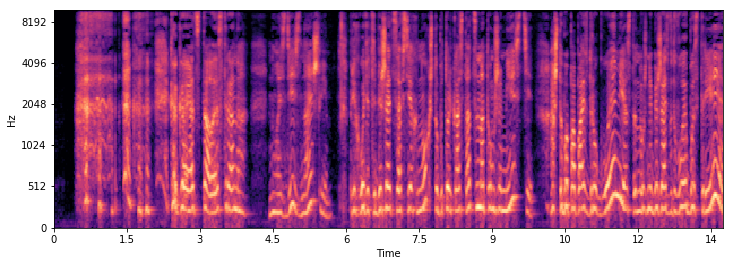

In [3]:
plt.figure(figsize=(12, 4))
n_fft = 2048
hop_length = 512
win_length = 4 * hop_length
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
librosa.display.specshow(librosa.power_to_db(mel, ref=np.max),
                          y_axis='mel', fmax=10000,
                          x_axis='time')

# Реконструкция

На вход алгоритма подается MEL спектр, на выходе звуковая волна, полученная алгоритмом Griffin-Lim из статьи 
"Signal estimation from modified short-time fourier transform" by Griffin and Lim,in IEEE transactions on Acoustics, Speech, and Signal Processing. Vol ASSP-32, No. 2, April 1984.

In [11]:
def griffin_lim(mel, sr, n_fft, win_length, hop_length, num_iters, 
                phase_angle=None, length=None, seed=None):
    mse = []
    filterbank = librosa.filters.mel(sr, n_fft, n_mels=mel.shape[0])
    spectrogram = filterbank.T @ mel
    magnitude = np.abs(spectrogram)
    if phase_angle is None:
        np.random.seed(seed)
        phase_angle = np.pi * np.random.rand(*magnitude.shape)
    spectrogram = magnitude * np.exp(1.j * phase_angle) #initialization
    for i in tqdm(range(num_iters), total=num_iters):
        y_hat = librosa.istft(spectrogram, win_length=win_length, 
                          hop_length=hop_length, length=length) #approx y
        
        if i == num_iters - 1:
            break
        _, phase = librosa.magphase(librosa.stft(y_hat, n_fft=n_fft, win_length=win_length, 
                                                 hop_length=hop_length))
        phase_angle = np.angle(phase)
        spectrogram = magnitude * np.exp(1.j * phase_angle)
        mse.append(((y - y_hat) ** 2).sum())
    return y_hat, mse

In [12]:
x_rec, mse = griffin_lim(mel, sr, n_fft, win_length, hop_length, 100)

 99%|█████████▉| 99/100 [00:18<00:00,  5.24it/s]

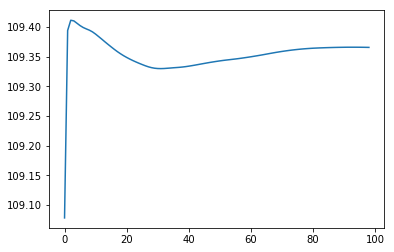

In [13]:
plt.plot(mse)

# Вывод результата

In [14]:
display(Audio(data=x_rec, rate=sr))

Оценка
- Генерация спектрограммы при помощи librosa(5)
- Синтезированный звук воспроизводится (20)